## Gemini GMOS Photometry reduction using DRAGONS Python API
#### from https://dragons.readthedocs.io/projects/gmosimg-drtutorial/en/v3.0.3/03_api_reduction.html
#### don't forget to run `conda install nb_conda_kernels ipykernel` to run this notebook on the DRAGONS env

**Importing Python Libraries**

In [1]:
from __future__ import print_function

import glob
import wget

from gempy.adlibrary import dataselect
from recipe_system import cal_service
from recipe_system.reduction.coreReduce import Reduce
from gempy.utils import logutils

from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cbook as cbook
from matplotlib.colors import LogNorm

%matplotlib inline

**Downloading the data**

In [ ]:
# wget.download("http://archive.gemini.edu/file/N20170613S0180.fits")
# wget.download("http://archive.gemini.edu/file/N20170613S0181.fits")
# wget.download("http://archive.gemini.edu/file/N20170613S0182.fits")
# wget.download("http://archive.gemini.edu/file/N20170613S0183.fits")
# wget.download("http://archive.gemini.edu/file/N20170613S0184.fits")
# wget.download("http://archive.gemini.edu/file/N20170614S0201.fits")
# wget.download("http://archive.gemini.edu/file/N20170614S0202.fits")
# wget.download("http://archive.gemini.edu/file/N20170614S0203.fits")
# wget.download("http://archive.gemini.edu/file/N20170614S0204.fits")
# wget.download("http://archive.gemini.edu/file/N20170614S0205.fits")
# wget.download("http://archive.gemini.edu/file/N20170615S0534.fits")
# wget.download("http://archive.gemini.edu/file/N20170615S0535.fits")
# wget.download("http://archive.gemini.edu/file/N20170615S0536.fits")
# wget.download("http://archive.gemini.edu/file/N20170615S0537.fits")
# wget.download("http://archive.gemini.edu/file/N20170615S0538.fits")
# wget.download("http://archive.gemini.edu/file/N20170702S0178.fits")
# wget.download("http://archive.gemini.edu/file/N20170702S0179.fits")
# wget.download("http://archive.gemini.edu/file/N20170702S0180.fits")
# wget.download("http://archive.gemini.edu/file/N20170702S0181.fits")
# wget.download("http://archive.gemini.edu/file/N20170702S0182.fits")

**Create and move data to raw/ directory**

In [ ]:
#!mkdir raw/
#!mv N*.fits raw/

**Setting up the DRAGONS logger**

In [ ]:
logutils.config(file_name='gmos_data_reduction.log')

**Setting up the Calibration Service**

First, check that you have already a `rsys.cfg` file inside the `~/.geminidr/`. It should contain:

```
[calibs]
standalone = True
database_dir = /path_to_my_data/gmosimg_tutorial_api/playground
```

In [ ]:
caldb = cal_service.CalibrationService()
caldb.config()
caldb.init()

cal_service.set_calservice()

**Create a list of all the FITS files in the directory**

In [ ]:
all_files = glob.glob('raw/*.fits')
all_files.sort()

**List of Biases**

In [ ]:
list_of_biases = dataselect.select_data(
    all_files,
    ['BIAS'],
    []
)

**List of Flats**

In [ ]:
list_of_flats = dataselect.select_data(
     all_files,
     ['FLAT'],
     [],
     dataselect.expr_parser('filter_name=="i"')
)

**List of Science Data**

In [ ]:
list_of_science = dataselect.select_data(
    all_files,
    [],
    ['CAL'],
    dataselect.expr_parser('(observation_class=="science" and filter_name=="i")')
)

**Make Master Bias**

In [ ]:
reduce_bias = Reduce()
reduce_bias.files.extend(list_of_biases)
reduce_bias.runr()

caldb.add_cal(reduce_bias.output_filenames[0])

**Make Master Flat**

In [ ]:
reduce_flats = Reduce()
reduce_flats.files.extend(list_of_flats)
reduce_flats.runr()

caldb.add_cal(reduce_flats.output_filenames[0])

**Reduce Science Images**

In [ ]:
reduce_science = Reduce()
reduce_science.files.extend(list_of_science)
reduce_science.runr()

**Display the Stacked Image**

In [2]:
image_file = "N20170614S0201_image.fits"
hdu_list = fits.open(image_file)
hdu_list.info()

Filename: N20170614S0201_image.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     214   ()      
  1  SCI           1 ImageHDU        90   (3245, 2264)   float32   
  2  VAR           1 ImageHDU        90   (3245, 2264)   float32   
  3  DQ            1 ImageHDU        90   (3245, 2264)   int16 (rescales to uint16)   
  4  PROVENANCE    1 BinTableHDU     21   7R x 4C   [28A, 128A, 128A, 128A]   
  5  PROVHISTORY    1 BinTableHDU     21   21R x 4C   [128A, 288A, 28A, 28A]   


In [3]:
image_data = fits.getdata(image_file, ext=1)
print(image_data.shape)

(2264, 3245)


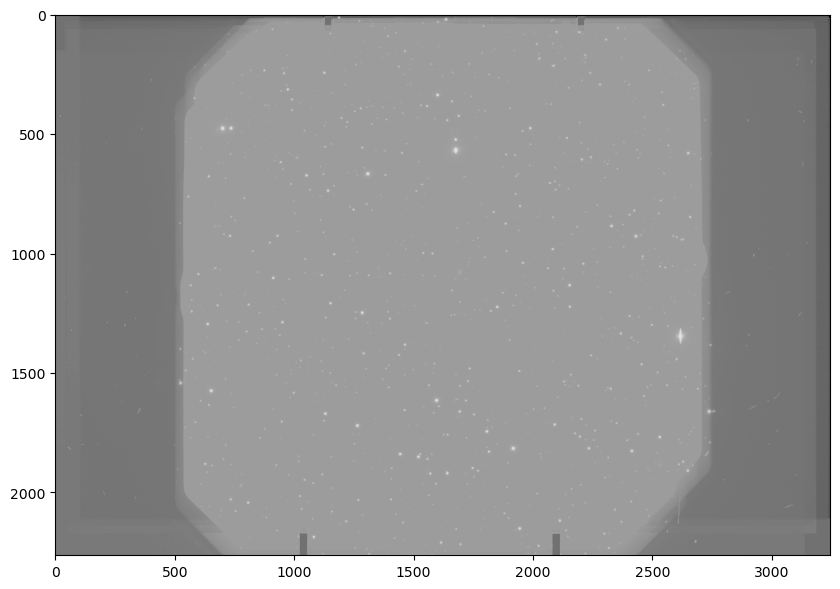

In [4]:
plt.figure(figsize = (10,10))
plt.imshow(image_data,cmap='gray',norm=LogNorm(vmin=0.01, vmax=1000000))
plt.show()

**Optional: remove duplicate calibrations and remove raw data (uncomment lines before running)**

In [ ]:
#!rm -rf *_bias.fits *_flat.fits
#!rm -rf raw/